In [1]:
# Analysis for CT Pretrial Detainees
# (Springboard Capstone 1)
# 2019, Misty M. Giles

# Import everything.  
%matplotlib inline
from datetime import datetime as date
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Select the file created in CT_csv (unit 5 data wrangling assignment)
file = 'detainees_classed_offenses.csv'

In [2]:
# Read in the file
df = pd.read_csv(file, parse_dates=['download_date', 'latest_admission_date'])

# This corrects a typo that's being fixed in CT_csv.
df['offense_class'] = [offense[-2:] if offense.endswith(('AM','BM','CM','DM','UM',' M', 
                       'AF','BF','CF','DF','UF',' F')) else np.nan for offense in df.offense]

# Days that CT says a detainee has been in the system.  This doesn't account for
# some detainees.  There are 730 days in the dataset, and the state says that entrance 
# dates over a year before could be original entrance date but are definitely not to be
# trusted.  The days column will be capped at 1,095 (730 + 365).  This is definitely going
#  to need further investigation.
df.days = [int(time[:-23]) for time in df.days]
df.days = [time if time <= 1095 else 1095 for time in df.days]

# Check that everything worked.  In this EDA, there should be 0 null values.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28808 entries, 0 to 28807
Data columns (total 13 columns):
download_date            28808 non-null datetime64[ns]
identifier               28808 non-null object
latest_admission_date    28808 non-null datetime64[ns]
race                     28808 non-null object
gender                   28808 non-null object
age                      28808 non-null int64
bond_amount              28808 non-null int64
offense                  28808 non-null object
facility                 28808 non-null object
detainer                 28808 non-null object
offense_class            28808 non-null object
days                     28808 non-null int64
counts                   28808 non-null int64
dtypes: datetime64[ns](2), int64(4), object(7)
memory usage: 2.9+ MB


In [3]:
# Only working with the 94% under 80k.
##### Now only 75% under 25k.
df = df.loc[df.bond_amount<=25000]

# Separate out the two datasets, misdemeanor (primary) and felony.
felony_df = df.loc[df['offense_class'].str.endswith('F')]
misdemeanor_df = df.loc[df['offense_class'].str.endswith('M')]

# Change race, gender, facility, and detainer to category type and verify.
misdemeanor_df.race = misdemeanor_df.race.astype('category')
misdemeanor_df.gender = misdemeanor_df.gender.astype('category')
misdemeanor_df.facility = misdemeanor_df.facility.astype('category')
misdemeanor_df.detainer = misdemeanor_df.detainer.astype('category')
misdemeanor_df.offense_class = misdemeanor_df.offense_class.astype('category')
print(misdemeanor_df.info())

# Divide the misdemeanor data into pre-enactment and post.
mis_pre_df = misdemeanor_df.loc[misdemeanor_df.download_date < '2017-07-01']
mis_post_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2017-07-01']
mis_post_df = mis_post_df.loc[mis_post_df.download_date < '2018-07-01']
mis_outofbounds_df = misdemeanor_df.loc[misdemeanor_df.download_date >= '2018-07-01']
mis_df = pd.concat([mis_pre_df, mis_post_df])

C:\Users\Misty\Anaconda3\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7491 entries, 3 to 28801
Data columns (total 13 columns):
download_date            7491 non-null datetime64[ns]
identifier               7491 non-null object
latest_admission_date    7491 non-null datetime64[ns]
race                     7491 non-null category
gender                   7491 non-null category
age                      7491 non-null int64
bond_amount              7491 non-null int64
offense                  7491 non-null object
facility                 7491 non-null category
detainer                 7491 non-null category
offense_class            7491 non-null category
days                     7491 non-null int64
counts                   7491 non-null int64
dtypes: category(5), datetime64[ns](2), int64(4), object(2)
memory usage: 564.9+ KB
None


In [4]:
target = pd.DataFrame(mis_pre_df.bond_amount)
data = mis_pre_df.drop(['identifier','bond_amount','counts', 
                        'download_date','latest_admission_date',
                        'offense','detainer','facility','age','days'], axis=1)
data = pd.get_dummies(data,columns=['offense_class','race','gender'])
data.drop('offense_class_UM',axis=1,inplace=True)
data.drop('race_ASIAN',axis=1,inplace=True)
data.drop('race_AMER IND',axis=1,inplace=True)
target.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061 entries, 3 to 28799
Data columns (total 9 columns):
offense_class_ M    3061 non-null uint8
offense_class_AM    3061 non-null uint8
offense_class_BM    3061 non-null uint8
offense_class_CM    3061 non-null uint8
race_BLACK          3061 non-null uint8
race_HISPANIC       3061 non-null uint8
race_WHITE          3061 non-null uint8
gender_F            3061 non-null uint8
gender_M            3061 non-null uint8
dtypes: uint8(9)
memory usage: 50.8 KB


((3061, 1), None)

# Restart everything.  Attempt log transforms after this.  

In [5]:
target_a = pd.DataFrame(mis_pre_df.bond_amount)
data_a = mis_pre_df.drop(['identifier','bond_amount','counts', 
                        'download_date','latest_admission_date',
                        'offense','detainer','facility'], axis=1)
data_a = pd.get_dummies(data_a,columns=['offense_class','race','gender'],drop_first=True)
#data_a.drop('offense_class_UM',axis=1,inplace=True)
#data_a.drop('race_ASIAN',axis=1,inplace=True)
#data_a.drop('race_AMER IND',axis=1,inplace=True)
data_a.drop(['offense_class_UM','race_ASIAN'],axis=1,inplace=True)
target_a.shape, data_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3061 entries, 3 to 28799
Data columns (total 9 columns):
age                 3061 non-null int64
days                3061 non-null int64
offense_class_AM    3061 non-null uint8
offense_class_BM    3061 non-null uint8
offense_class_CM    3061 non-null uint8
race_BLACK          3061 non-null uint8
race_HISPANIC       3061 non-null uint8
race_WHITE          3061 non-null uint8
gender_M            3061 non-null uint8
dtypes: int64(2), uint8(7)
memory usage: 92.7 KB


((3061, 1), None)

# Linear log after cutting data down to <25k, doesn't help the score at all.

In [6]:
X = data_a.loc[target_a.bond_amount<=10000]
y = target_a.loc[target_a.bond_amount<=10000].transform(lambda x: np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

lin = LinearRegression()
lin.fit(X_train,y_train)
lin.predict(X_test)
lin.score(X_test,y_test)

0.03696892326420298

Statsmodels is now same as other models

In [7]:
X = data_a
y = target_a.transform(lambda x: np.log(x))
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

linear = sm.OLS(y_train,X_train).fit()
predict = linear.predict(X_test)
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     10.22
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           1.51e-15
Time:                        17:01:18   Log-Likelihood:                -3692.1
No. Observations:                2142   AIC:                             7404.
Df Residuals:                    2132   BIC:                             7461.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.8605      0.293  

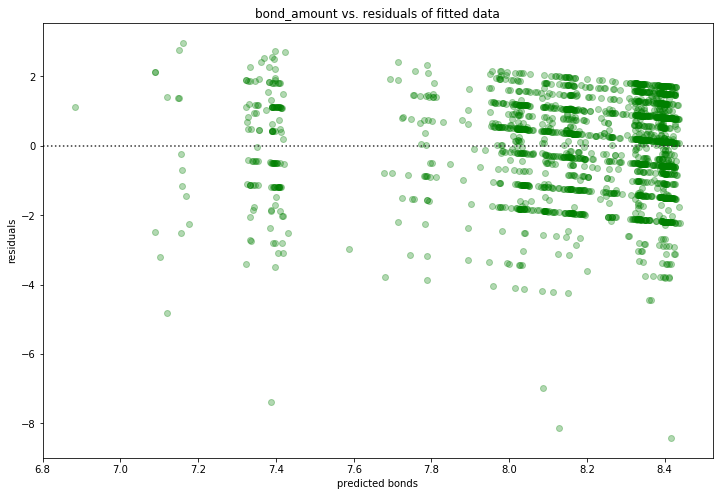

In [8]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(linear.fittedvalues, linear.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

Text(0,0.5,'fitted')

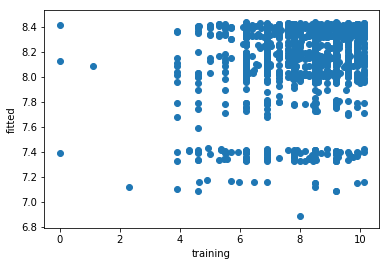

In [9]:
plt.scatter(y_train,linear.fittedvalues)
plt.xlabel('training')
plt.ylabel('fitted')

# So even though the training values go to 25k, the fitted vals only go to 8k...

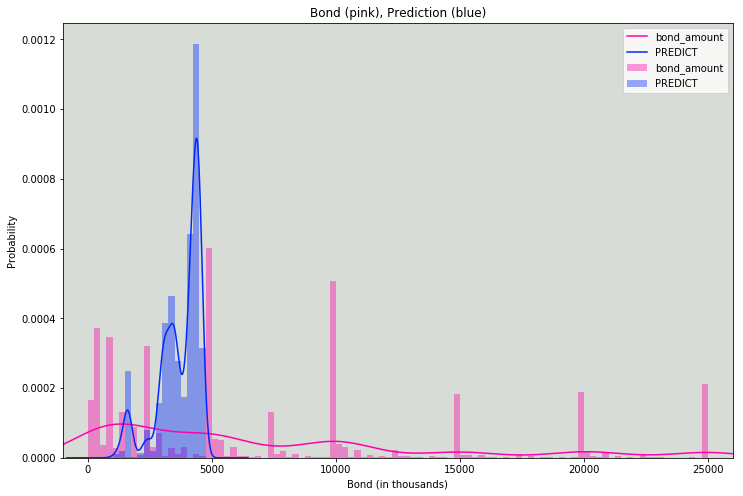

In [10]:
plt_75 = target_a.copy()
plt_75['PREDICT'] = linear.fittedvalues.transform(lambda x: np.exp(x))

from matplotlib import cm
color_country = cm.hsv(np.linspace(.9,.65, 2))
dist = plt_75[['bond_amount', 'PREDICT']].copy()
fig, ax = plt.subplots(figsize=(12,8))
dist.plot.kde(ax=ax, title='Bond (pink), Prediction (blue)', color=color_country)
dist.plot.hist(density=True, ax=ax, alpha=.4, color=color_country, bins=100)
ax.set_ylabel('Probability')
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('Bond (in thousands)')
ax.set_xlim(-1000,26000);

# Attempt at KNN Regression.  Same issues as Linear.

As usual, I like this idea.  I just cannot figure out how to make plots from it to even start seeing where I'm going wrong.

In [11]:
X = data_a.loc[target_a.bond_amount<=10000]
y = target_a.loc[target_a.bond_amount<=10000].transform(lambda x: np.log(x))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

knr = KNeighborsRegressor(n_neighbors=11).fit(X_train,y_train)

knr.predict(X_test)
knr.score(X_test,y_test)

-0.047593763779396614

# Here's statsmodels with 10k.  It doesn't matter what I choose.  The predicts cut off at 4000 when 10k is chosen and cut off at 3500 when 7.5k (the median) is chosen.

In [12]:
X = data_a.loc[target_a.bond_amount<=10000]
y = target_a.loc[target_a.bond_amount<=10000].transform(lambda x: np.log(x))
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

linear = sm.OLS(y_train,X_train).fit()
predict = linear.predict(X_test)
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     9.475
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           3.49e-14
Time:                        17:01:24   Log-Likelihood:                -2719.7
No. Observations:                1682   AIC:                             5459.
Df Residuals:                    1672   BIC:                             5514.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.2385      0.309  

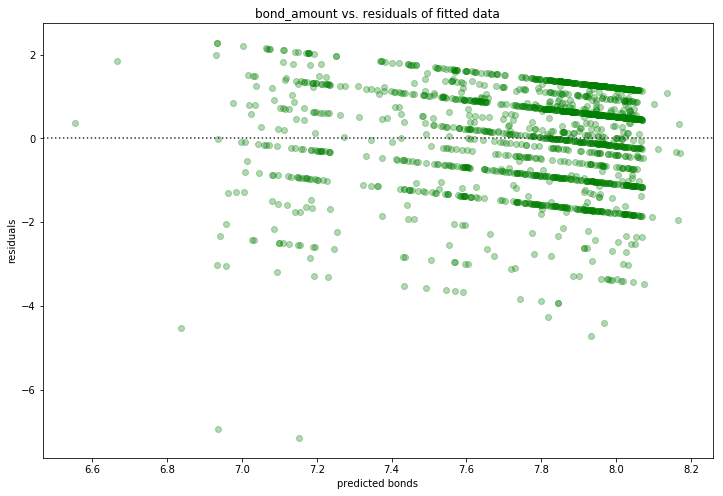

In [13]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(linear.fittedvalues, linear.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

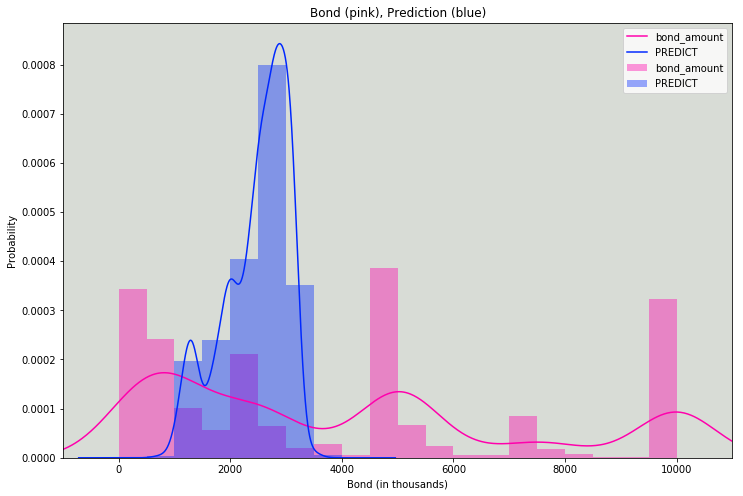

In [14]:
plt_50 = target_a.loc[target_a.bond_amount<=10000].copy()
plt_50['PREDICT'] = linear.fittedvalues.transform(lambda x: np.exp(x))

from matplotlib import cm
color_country = cm.hsv(np.linspace(.9,.65, 2))
dist = plt_50[['bond_amount', 'PREDICT']].copy()
fig, ax = plt.subplots(figsize=(12,8))
dist.plot.kde(ax=ax, title='Bond (pink), Prediction (blue)', color=color_country)
dist.plot.hist(density=True, ax=ax, alpha=.4, color=color_country, bins=20)
ax.set_ylabel('Probability')
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('Bond (in thousands)')
ax.set_xlim(-1000,11000);

In [15]:
X = data_a.loc[target_a.bond_amount<=5000].copy()
y = target_a.loc[target_a.bond_amount<=5000].copy().transform(lambda x: np.log(x))
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

linear = sm.OLS(y_train,X_train).fit()
predict = linear.predict(X_test)
print(linear.summary())

                            OLS Regression Results                            
Dep. Variable:            bond_amount   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     10.28
Date:                Mon, 15 Apr 2019   Prob (F-statistic):           2.09e-15
Time:                        17:01:28   Log-Likelihood:                -1875.3
No. Observations:                1227   AIC:                             3771.
Df Residuals:                    1217   BIC:                             3822.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.7160      0.328  

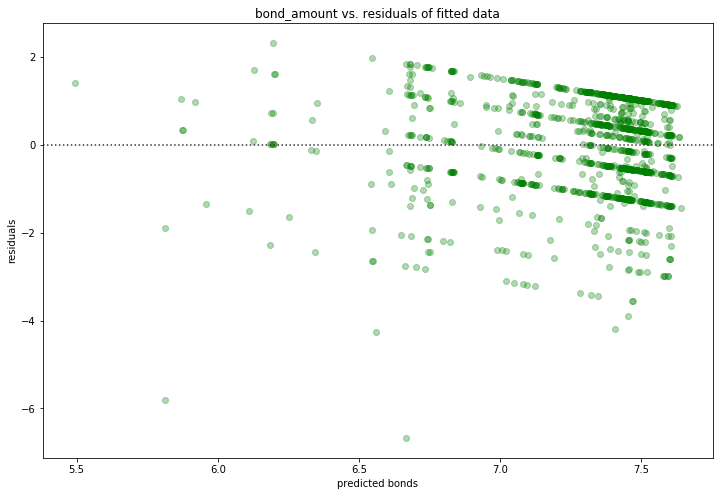

In [16]:
# Plot the bond_amount vs the residuals
_ = plt.figure(figsize=(12,8))
_ = sns.residplot(linear.fittedvalues, linear.resid, color='g', scatter_kws={'alpha': .3}, 
                  line_kws={'color':'purple', 'alpha':.8})
_ = plt.xlabel('predicted bonds')
_ = plt.ylabel('residuals')
_ = plt.title('bond_amount vs. residuals of fitted data')

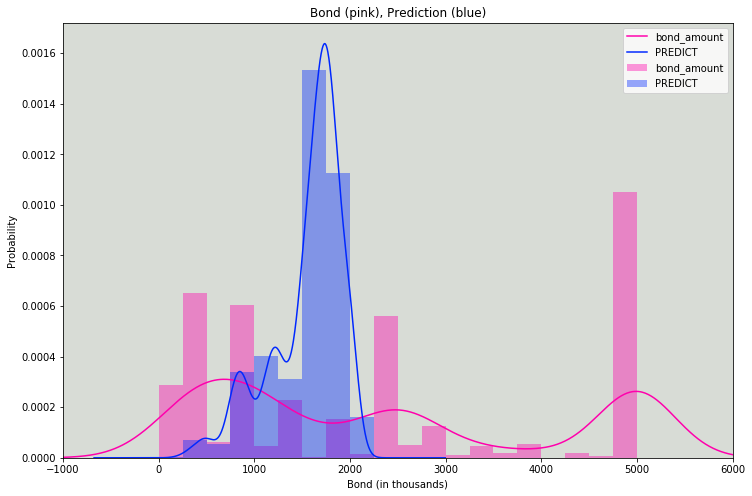

In [17]:
plt_5k = target_a.loc[target_a.bond_amount<=5000].copy()
plt_5k['PREDICT'] = linear.fittedvalues.transform(lambda x: np.exp(x))

from matplotlib import cm
color_country = cm.hsv(np.linspace(.9,.65, 2))
dist = plt_5k[['bond_amount', 'PREDICT']].copy()
fig, ax = plt.subplots(figsize=(12,8))
dist.plot.kde(ax=ax, title='Bond (pink), Prediction (blue)', color=color_country)
dist.plot.hist(density=True, ax=ax, alpha=.4, color=color_country, bins=20)
ax.set_ylabel('Probability')
ax.set_facecolor('#d8dcd6')
ax.set_xlabel('Bond (in thousands)')
ax.set_xlim(-1000,6000);